<center><img src="img.png" width='800' height='350'><center>

### Mise en place d'une solution automatisable de l'analyse des ventes en ligne de la boutique Bottleneck fine wine spirit 

### Les fichiers fournis :
* #### Erp : Fichier Excel de 5 colonnes avec le prix, les référence produit et l'état de stock
* #### Web : Fichier Excel contenant 28 colonnes sur les informations des produits commercialisés en ligne (Nom, description, nombre de ventes...)
* #### Liaison : Fichier Excel avec 2 colonnes fait par Sylvie pour lier Erp et Web

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  
import openpyxl as opx
import warnings
warnings.filterwarnings("ignore")

In [33]:
erp = pd.read_excel("erp.xlsx")
liaison = pd.read_excel("liaison.xlsx")
web = pd.read_excel("web.xlsx")
web.rename(columns={'sku':'id_web'}, inplace=True)
web = web.loc[web["post_type"] == 'product']
web = web[web["id_web"].notnull()]

In [34]:
#display(erp)
#display(liaison)
#display(web)

## Préparation de la data 

In [35]:
df = pd.merge(erp,liaison,on='product_id',how='outer',indicator=True)
df.loc[df["_merge"] != "both"]

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,_merge


### Chaque ligne du fichier ERP à une réference dans le fichier Liaison

In [36]:
del df["_merge"]

In [37]:
data = pd.merge(df, web, on='id_web', how='outer', indicator=True)
data_final = data.loc[data["_merge"] == "both", ['post_name','price','total_sales']]
data_final["Total"] = data_final["price"] * data_final["total_sales"]
data_final.isnull().sum()

post_name      0
price          0
total_sales    0
Total          0
dtype: int64

## Calcul du chiffre d'affaires total et par produits 

In [38]:
display(data_final.sort_values('Total', ascending=False))
print("Le Chiffre d'affaires total est de",data_final["Total"].sum(),"Euros")

,post_name,price,total_sales,Total
286,champagne-gosset-grand-blanc-de-blanc,49.0,96.0,4704.0
162,champagne-gosset-grand-rose,49.0,87.0,4263.0
310,cognac-frapin-vip-xo,176.0,13.0,2288.0
161,champagne-gosset-grand-millesime-2006,53.0,30.0,1590.0
160,gosset-champagne-grande-reserve,39.0,40.0,1560.0
...,...,...,...,...
447,maurice-schoech-pinot-noir-piece-de-chene-2016,13.6,0.0,0.0
446,maurice-schoech-riesling-2018,11.1,0.0,0.0
443,maurice-schoech-gewurztraminer-2018,12.1,0.0,0.0
441,maurice-schoech-riesling-vendanges-tardives-2017,28.5,0.0,0.0


Le Chiffre d'affaires total est de 70568.6 Euros


## Analyse statistique des prix de ventes des bouteilles

In [39]:
price = data_final["price"]

outlier = price.describe()

print("Il y a",round(outlier[0]),"références produit dans la dataset")
print("Le prix moyen d'une bouteille est de",round(outlier[1],1),"€")
print("l'écart type est de",round(outlier[2],1),"€")
print("Le premier quartile est de",round(outlier[4],1),"€ et le troisieme est de",round(outlier[6],1),"€")
print("La médiane est de", round(outlier[5],1),"€")

Il y a 714 références produit dans la dataset
Le prix moyen d'une bouteille est de 32.5 €
l'écart type est de 27.8 €
Le premier quartile est de 14.1 € et le troisieme est de 42.2 €
La médiane est de 23.6 €


### Calcul via l'écart type des valeurs abérantes

In [48]:
limit_sup = outlier[1] + 1.5 * outlier[2]
limit_inf = outlier[1] - 1.5 * outlier[2]

print("Les valeurs abérantes se situent en dehors de",round(limit_inf,1),'€ et',round(limit_sup,1),"€")


Les valeurs abérantes se situent en dehors de -9.2 € et 74.2 €


### Calcul via l'écart interquartile des valeurs abérantes

In [49]:
lower_terminal = outlier[4] - (1.5 * (outlier[6]-outlier[4]))

upper_terminal = outlier[6] + (1.5 * (outlier[6]-outlier[4]))

print("La borne supérieure est à", round(upper_terminal,1),'€')
print("La borne inférieure est à", round(lower_terminal,1),'€')


La borne supérieure est à 84.3 €
La borne inférieure est à -28.0 €


### Calcul via le Z-score des valeurs abérantes

In [42]:
data_final["zscore"] = (data_final["price"]-np.mean(data_final["price"]))/np.std(data_final["price"])
data_final.loc[np.abs(data_final["zscore"]) > 2,["post_name","price"]].sort_values('price', ascending=False)


,post_name,price
291,champagne-egly-ouriet-grand-cru-millesime-2008,225.0
525,david-duband-charmes-chambertin-grand-cru-2014,217.5
692,coteaux-champenois-egly-ouriet-ambonnay-rouge-...,191.3
310,cognac-frapin-vip-xo,176.0
657,camille-giroud-clos-de-vougeot-2016,175.0
313,cognac-frapin-chateau-de-fontpinot-1989-20-ans,157.0
478,domaine-des-croix-corton-charlemagne-grand-cru...,137.0
752,champagne-gosset-celebris-vintage-2007,135.0
293,champagne-egly-ouriet-grand-cru-brut-blanc-de-...,126.5
615,domaine-weinbach-gewurztraminer-gc-furstentum-...,124.8


## Représentation graphique

### Digramme en boite à moustaches

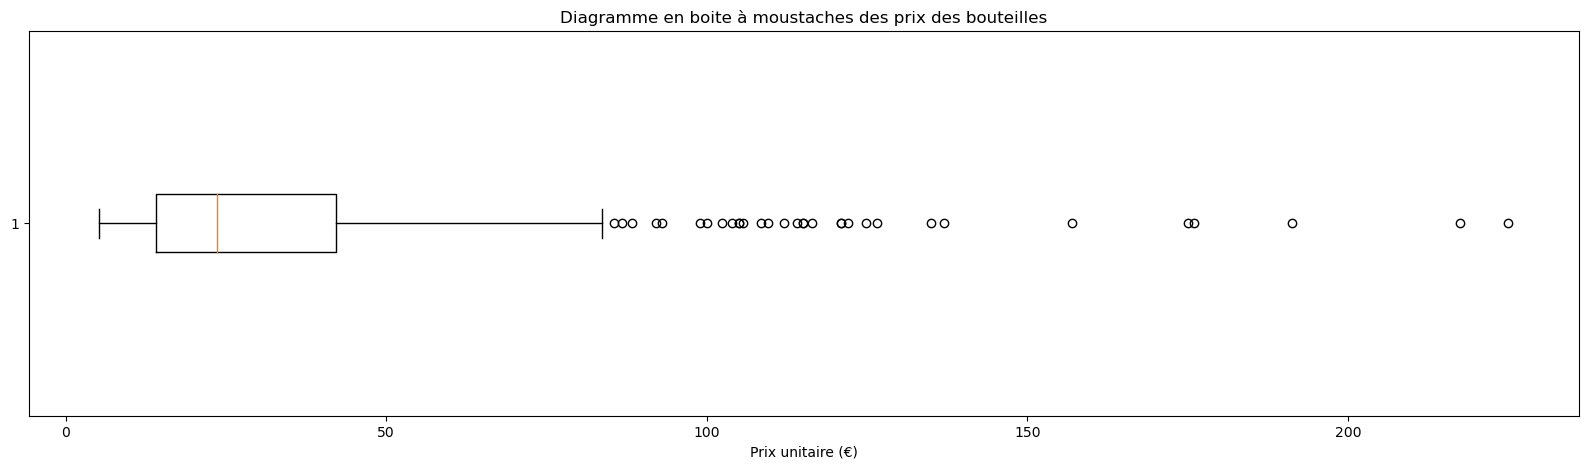

In [50]:
plt.figure(figsize=(20,5))
plt.boxplot(price, vert=False)
plt.xlabel('Prix unitaire (€)')
plt.title('Diagramme en boite à moustaches des prix des bouteilles')
plt.show()

### Nuage de point des prix unitaires

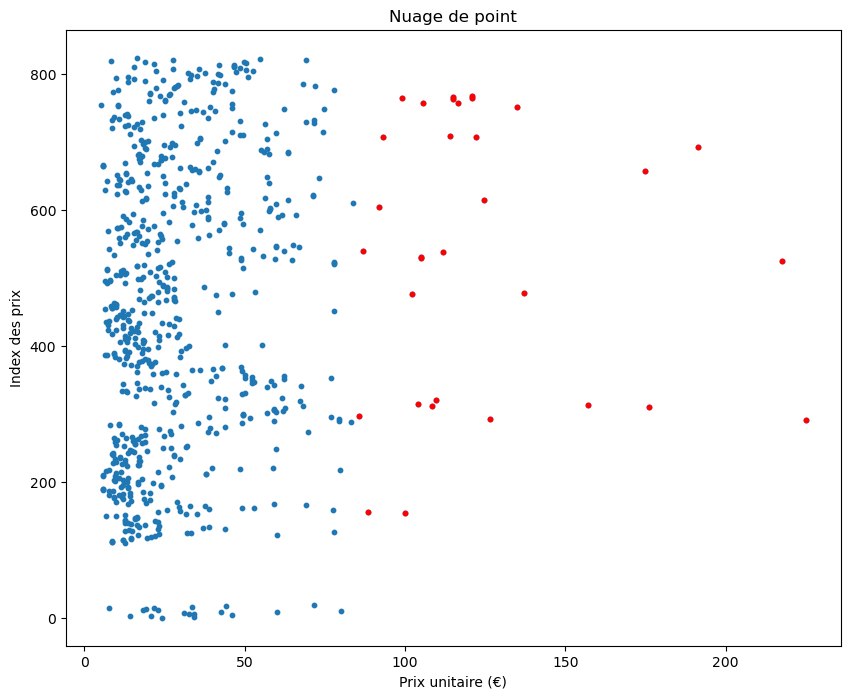

In [52]:
red = data_final.loc[data_final["price"] > upper_terminal,:]

plt.figure(figsize=(10,8))
plt.scatter(data_final['price'],data_final['price'].index,s=10)
plt.scatter(red["price"],red['price'].index,s=10,color='r')
plt.title('Nuage de point')
plt.xlabel("Prix unitaire (€)")
plt.ylabel("Index des prix")
plt.show()

In [45]:
data_final.loc[data_final["price"] > upper_terminal,"price"].count()

32

In [46]:
data_final.loc[data_final["price"] > limit_sup].head(20).sort_values('price',ascending=False)

,post_name,price,total_sales,Total,zscore
291,champagne-egly-ouriet-grand-cru-millesime-2008,225.0,5.0,1125.0,6.926939
310,cognac-frapin-vip-xo,176.0,13.0,2288.0,5.163781
313,cognac-frapin-chateau-de-fontpinot-1989-20-ans,157.0,0.0,0.0,4.480108
293,champagne-egly-ouriet-grand-cru-brut-blanc-de-...,126.5,11.0,1391.5,3.382632
320,chateau-de-puligny-montrachet-1cru-champ-canet...,109.6,0.0,0.0,2.774522
311,cognac-frapin-fontpinot-xo,108.5,2.0,217.0,2.734941
314,cognac-frapin-cigar-blend,104.0,1.0,104.0,2.573018
154,zind-humbrecht-riesling-gc-rangen-thann-clos-s...,100.0,0.0,0.0,2.429087
156,zind-humbrecht-pinot-gris-grand-cru-rangen-de-...,88.4,0.0,0.0,2.011686
297,champagne-larmandier-bernier-grand-cru-vieille...,85.6,1.0,85.6,1.910934
